In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette('colorblind')
%matplotlib inline
np.random.seed(88)

In [2]:
# random weakly informative features copied from
# https://github.com/ORIE4741/demos/blob/master/double-descent.ipynb
def build_random_features(n=100, d=100, num_informative_features = 20):
    y = np.random.randn(n)
    X = np.random.randn(n, min(d, num_informative_features)) + y.reshape(-1,1)

    if d > num_informative_features:
        X = np.hstack((X, np.random.randn(n,d - num_informative_features)))
    
    return X,y


In [3]:
def eff_dim(x, s=0.1):
    return np.sum(x / (x + s))

In [4]:
def compute_partial_error(d, n=200, l=0.001):
    xtrain, ytrain = build_random_features(n=n, d = d, num_informative_features=1000)
    xtest, ytest = build_random_features(n=n, d = d, num_informative_features=1000)

    w = np.linalg.lstsq(xtrain, ytrain, rcond=None)[0]
    
    alpha = np.linalg.lstsq(xtrain @ xtrain.T +  n * l * np.eye(xtrain.shape[0]), ytrain)[0]
    train_norm = alpha.T @ xtrain @ (xtrain.T @ alpha)
    
    test_error = np.linalg.norm(xtest @ w - ytest) / np.linalg.norm(ytest)
    train_error = np.linalg.norm(xtrain @ w - ytrain) / np.linalg.norm(ytrain)
    
    svs = np.linalg.svd(xtrain, compute_uv=False)
    #eigs = np.linalg.eigvals(xtrain @ xtrain.T)
    effective_dimensions = min(n, d) - eff_dim(svs**2, s=(l*n))
    
    return test_error, train_error, train_norm**0.5, effective_dimensions, svs

In [5]:
width_sequence = range(5, 400, 2)
errors = [compute_partial_error(d) for d in width_sequence]

/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


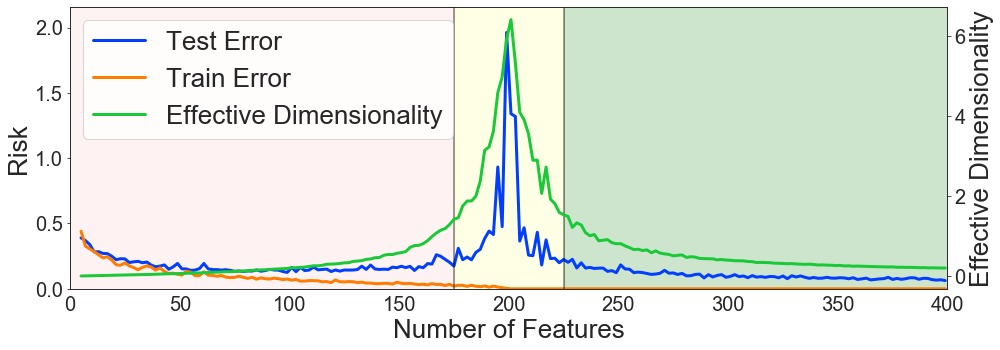

In [6]:
title_fs = 28
ax_fs = 26
leg_fs = 26
tick_size = 20
lw = 3.

sns.set_style("white")
colors = sns.color_palette("bright")
fig, ax = plt.subplots(1, 1, figsize=(14,5))
ax.plot(width_sequence, [e[0] for e in errors], label='Test Error', color=colors[0],
       linewidth=lw)
ax.plot(width_sequence, [e[1] for e in errors], label='Train Error', color=colors[1],
       linewidth=lw)
ax.tick_params(axis='both', labelsize=tick_size)
#ax.plot(width_sequence, [e[2] for e in errors], label='Hilbert Space Norm')

ax2 = ax.twinx()
ax2.plot(width_sequence, [e[3] for e in errors], label = 'Effective Dimensionality', color=colors[2],
        linewidth=lw)
ax2.tick_params(axis='y', labelsize=tick_size)

ymin = 0
ymax = 1.1 * max([e[0] for e in errors])
ax.set_ylim(ymin, ymax)
ax.axvspan(0, 175, alpha=0.05, color='red')
ax.axvspan(175, 225, alpha=0.1, color='yellow')
ax.axvspan(225, 400, alpha=0.2, color='green')

# ax.fill_between([175, 225], ymin, ymax, facecolor="None", edgecolor='k', hatch="/",
#                 alpha=0.2)
# ax.fill_between([225, 400], ymin, ymax, facecolor="None", edgecolor='k', hatch="X",
#                 alpha=0.2)
ax.axvline(175, color='k', alpha=0.5)
ax.axvline(225, color='k', alpha=0.5)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=leg_fs)
#ax.legend()

ax.set_ylabel('Risk', fontsize=ax_fs)
ax.set_xlabel('Number of Features', fontsize=ax_fs)
ax2.set_ylabel('Effective Dimensionality', fontsize=ax_fs)
#plt.ylim((0, 0.3))
plt.xlim((0,400))
plt.tight_layout()
plt.savefig('./random_featues_double_descent.pdf', bbox_inches='tight')

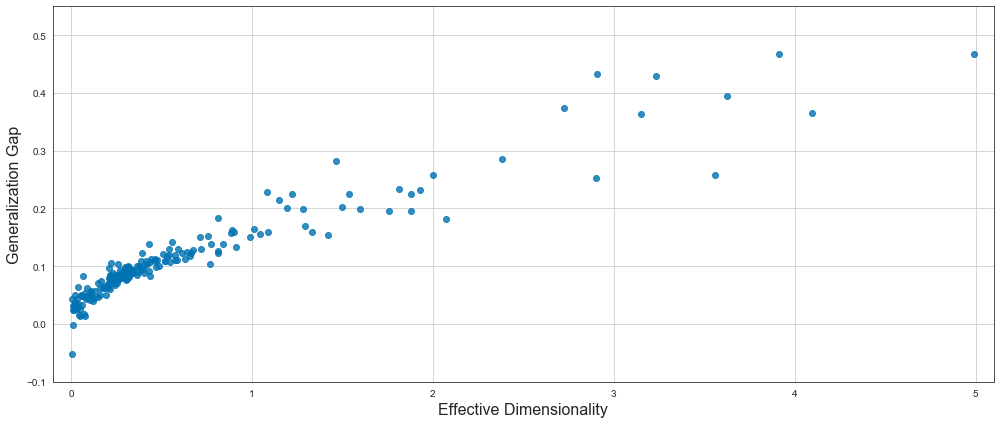

In [40]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(14,6))

plt.scatter([e[3] for e in errors], [e[0] - e[1] for e in errors], alpha = 0.8)

plt.xlabel('Effective Dimensionality', fontsize=16)
plt.ylabel('Generalization Gap', fontsize=16)
plt.grid()
plt.ylim((-0.1, 0.55))
plt.xlim((-0.1, 5.1))
plt.tight_layout()
plt.savefig('random_features_generalization.pdf', bbox_inches="tight")

In [9]:
dimensions = range(10, 1200, 20)
data_points = range(10, 1200, 20)

risk_tensor = np.zeros((4, len(list(dimensions)), len(list(dimensions))))
for i, d in enumerate(dimensions):
    for j, n in enumerate(data_points):
        output = compute_partial_error(d=d, n=n)
        risk_tensor[:, i, j] = output[:-1]

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))

im = ax[0].contourf(dimensions, data_points, np.log(risk_tensor[0]))
ax[0].set_ylabel('Number of Random Features')
ax[0].set_xlabel('Number of Data Points')
ax[0].set_title('Test Error')
fig.colorbar(im, label='Log(Test Error)', ax=ax[0])

im = ax[1].contourf(dimensions, data_points, np.log(risk_tensor[1]))
ax[1].set_title('Train Error')
ax[1].set_ylabel('Number of Random Features')
ax[1].set_xlabel('Number of Data Points')
fig.colorbar(im, label='Train Error', ax=ax[1])

im = ax[2].contourf(dimensions, data_points, np.log(risk_tensor[2]))
ax[2].set_title('Hilbert Space Norm')
ax[2].set_ylabel('Number of Random Features')
ax[2].set_xlabel('Number of Data Points')
fig.colorbar(im, label='Log(Hilbert Space Norm)',ax=ax[2])

plt.tight_layout()

In [ ]:
plt.contourf(dimensions, data_points, risk_tensor[1])
plt.colorbar(label='Train Error')
plt.xlabel('Number of Data Points')
plt.ylabel('Number of Random Features')


In [ ]:
plt.imshow(np.log(risk_tensor[2]), extent=[10, 1000, 1000, 10])
plt.colorbar()
plt.xlabel('Number of Data Points')
plt.ylabel('Number of Random Features')

In [ ]:
plt.contourf(dimensions, data_points, np.log(risk_tensor[2]))
plt.xlabel('Number of Random Features')
plt.ylabel('Number of Data Points')
plt.colorbar(label='Log(Hilbert Space Norm)')

In [ ]:
svds = [np.linalg.svd(build_random_features(n=200, d = d, 
                                            num_informative_features=1000)[0])[1] for d in range(10, 1000, 5)]

In [ ]:
colors = ['blue', 'red']
for s, d in zip(svds, range(10, 1000, 5)):
    plt.plot(2*np.log(s+3), color = colors[d < 150 or d > 250])
plt.xlabel('Order')
plt.ylabel('Log Eigenvalue')